# Windspeed Prediction Model Development

## ConvLSTM: Time-Series Approach

1. Why did you choose this model?

   This ConvLSTM model combines the advantages of CNN and LSTM, making it well-suited for processing data with spatial and temporal dimensions. It uses ResNet18 as the backbone for the CNN, which can efficiently extract complex features from image data. Additionally, the inclusion of extra convolutional and fully connected layers allows for adjustable parameters as needed. The concept of this model was inspired by the model used by [team vecxoz](https://github.com/drivendataorg/wind-dependent-variables)
 in the Wind-dependent Variables competition, but it was simplified due to differences in the dataset.

2. What was promising about it?

   CNNs are very good at extracting features from images, which is why they are commonly used in practical applications. The presence of LSTM makes it particularly effective for predicting phenomena affected by spatiotemporal factors. Furthermore, this model can also be applied to other scenarios such as traffic flow.

3. What was its architecture?

   It first uses a CNN to extract spatial features from the input data, then passes these features to an LSTM to process time-series data, capturing the dynamic changes over time. This structure allows the model to effectively process and integrate spatial and temporal information, making it suitable for various spatiotemporal sequence prediction tasks. The specific architecture is as follows.

4. Why did you not end up choosing it?

   After training on a dataset that included 31 storms, including `tst`, the model showed strong generalization ability but performed weakly in predicting `tst`. This was particularly evident when comparing actual values to predicted values, where the fit was poor for the last few data points. Therefore, it was concluded that this model performed poorly on the `tst` dataset.

### Data Loader

First, we set `seq_length=4`, meaning we use the first 4 data points to predict the next one, and so on. However, when we set `seq_length` to 50, the model can capture features better, and the MSE loss will be lower, but the training time will be very, very long. Therefore, for the usability of the model, we reduce the `seq_length`.

In [ ]:
import json
import os
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, base_path, seq_length, transform=None):
        """
        Initialize the dataset
        base_path: The base path where the image sequences are stored
        seq_length: The length of the sequences
        transform: Transformations to apply to the images
        """
        self.base_path = base_path
        self.seq_length = seq_length
        self.transform = transform

        self.sequences = []
        folders = [os.path.join(base_path, f) for f in os.listdir(base_path) if f != "__MACOSX"]
        for folder in folders:
            images = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.jpg')])
            for i in range(len(images) - seq_length):
                self.sequences.append(images[i:i + seq_length])

    def __len__(self):
        """
        Return the number of samples in the dataset
        """
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Return a sample and its corresponding next time step's wind_speeds
        """
        image_paths = self.sequences[idx]

        sequence = []
        for img_path in image_paths:
            image = Image.open(img_path).convert("L")
            if self.transform:
                image = self.transform(image)
            sequence.append(image)

        sequence_tensor = torch.stack(sequence)

        next_sequence_paths = self.sequences[min(idx + 1, len(self.sequences) - 1)]
        wind_speeds = []
        for img_path in next_sequence_paths:
            json_path = os.path.splitext(img_path)[0] + '_label.json'
            with open(json_path, 'r') as f:
                wind_speed = float(json.load(f)['wind_speed'])
                wind_speeds.append(wind_speed)

        wind_speed_tensor = torch.tensor(wind_speeds).float().unsqueeze(1)

        return sequence_tensor, wind_speed_tensor

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = TimeSeriesDataset("/content/data", seq_length=4, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Model

The `ConvLSTMModel` is a neural network architecture that combines convolutional neural networks (CNNs) and Long Short-Term Memory (LSTM) networks, designed to process sequential image data. It's implemented using PyTorch. Here's a breakdown of its components and functionality:

1. **Initialization (`__init__` method)**:
   - Inherits from `nn.Module`.
   - Initializes a CNN backbone (ResNet18) with pretrained weights.
   - Modifies the first convolutional layer to adapt to the number of input channels (supports grayscale images).
   - Removes the last two layers (average pooling and fully connected) of ResNet18.
   - Adds an additional Conv2D layer and an adaptive average pooling layer.
   - Initializes an LSTM layer for processing temporal sequences.
   - Adds two fully connected layers for output predictions.

2. **CNN Backbone (ResNet18)**:
   - Used to extract spatial features from images.
   - The first convolutional layer is modified to handle a specific number of input channels.
   - The last two layers of ResNet18 are removed to adapt it for feature extraction.

3. **Additional Conv2D and Pooling Layers**:
   - The Conv2D layer further processes the features extracted by the CNN.
   - The adaptive average pooling layer reduces the spatial dimensions of the feature maps.

4. **LSTM Layer**:
   - Processes the time sequences of the extracted features.
   - Capable of capturing temporal dependencies in the data.
   - Outputs feature representations for all time steps.

5. **Fully Connected Layers**:
   - Two linear layers with a ReLU activation in between.
   - Transform the LSTM output to final predictions.
   - The output dimensions correspond to the number of classes.

6. **Forward Pass (`forward` method)**:
   - Accepts an input tensor of shape `[batch_size, time_steps, channels, height, width]`.
   - Processes each time step individually through the CNN.
   - Additional Conv2D and pooling layers further process the CNN output.
   - Reshaped data is fed into the LSTM to capture temporal information.
   - Fully connected layers process LSTM outputs for each time step.
   - The final output is reshaped to match the number of time steps.

   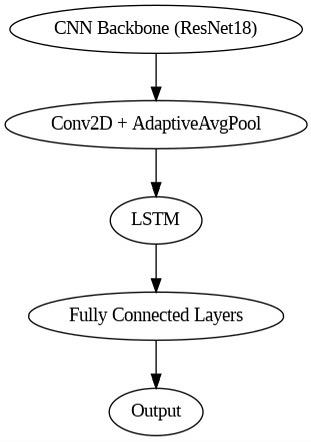


In [ ]:
class ConvLSTMModel(nn.Module):
    def __init__(self, args):
        super(ConvLSTMModel, self).__init__()
        self.model_interim = args.model_func(pretrained=args.weights)

        original_first_layer = self.model_interim.conv1
        self.model_interim.conv1 = nn.Conv2d(args.n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            self.model_interim.conv1.weight[:, :args.n_channels, :, :] = original_first_layer.weight[:, :args.n_channels, :, :]

        self.model_interim = nn.Sequential(*(list(self.model_interim.children())[:-2]))

        self.conv = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=1, padding=1)

        self.pool_2d = nn.AdaptiveAvgPool2d((1, 1))
        
        self.lstm = nn.LSTM(512, 1024, batch_first=True)
        self.fc1 = nn.Linear(1024, 300)
        self.fc2 = nn.Linear(300, args.n_classes)

    def forward(self, x):
        batch_size, time_steps, C, H, W = x.size()
        c_in = x.view(batch_size * time_steps, C, H, W)
        c_out = self.model_interim(c_in)

        c_out = self.conv(c_out)

        c_out = self.pool_2d(c_out)
        c_out = c_out.view(batch_size, time_steps, -1)

        lstm_out, (h_n, c_n) = self.lstm(c_out)

        lstm_out = lstm_out.contiguous().view(batch_size * time_steps, -1)

        out = torch.relu(self.fc1(lstm_out))
        out = self.fc2(out)

        out = out.view(batch_size, time_steps, -1)

        return out

class Args:
    volume_size = 8
    dim = 64
    n_channels = 1
    model_func = models.resnet18
    weights = models.ResNet18_Weights.DEFAULT
    include_top = False
    n_classes = 1
    lr = 1e-4
    metric_name = 'rmse'

In [ ]:
args = Args()

model = ConvLSTMModel(args)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = nn.MSELoss()

epochs = 15
train_losses = []

for epoch in tqdm(range(epochs)):
    # Training process
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()
        
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

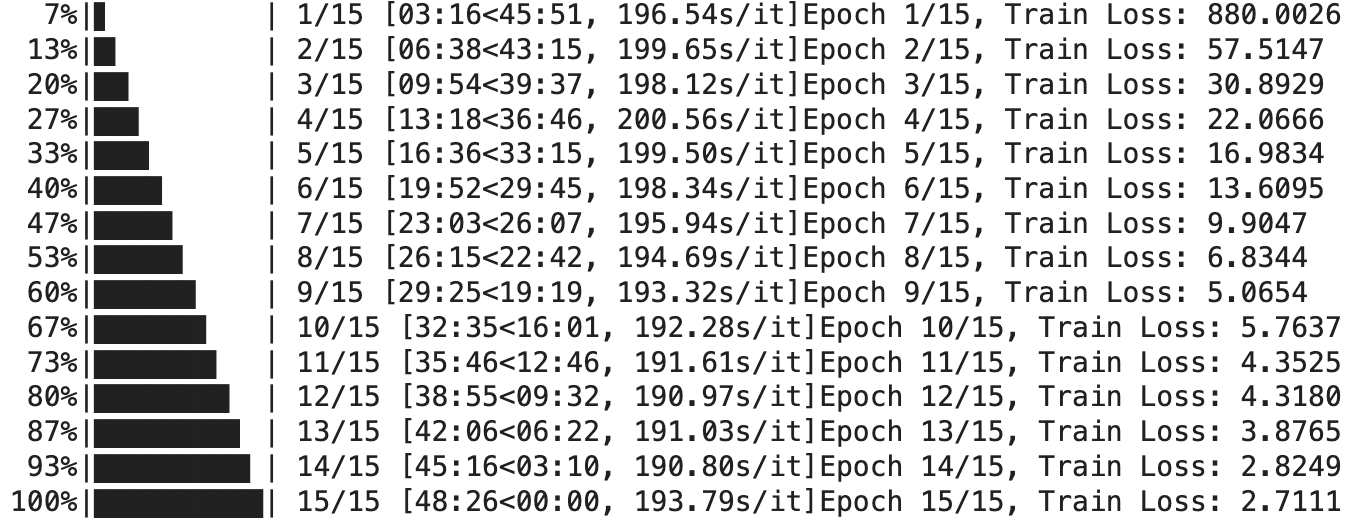

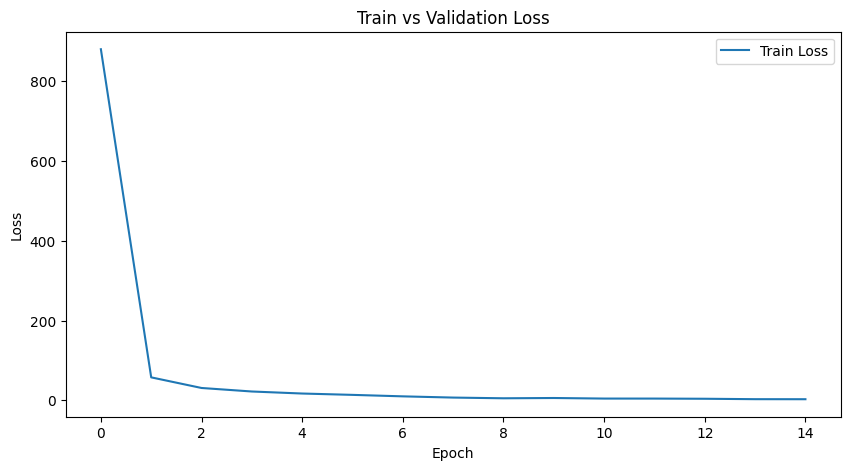

It seems to fit well, but I'm not sure if there have been any over-fitting problems.

# Model performance in `tst` dataset and prediction



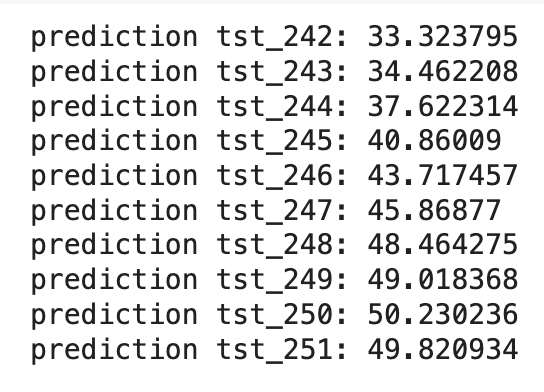

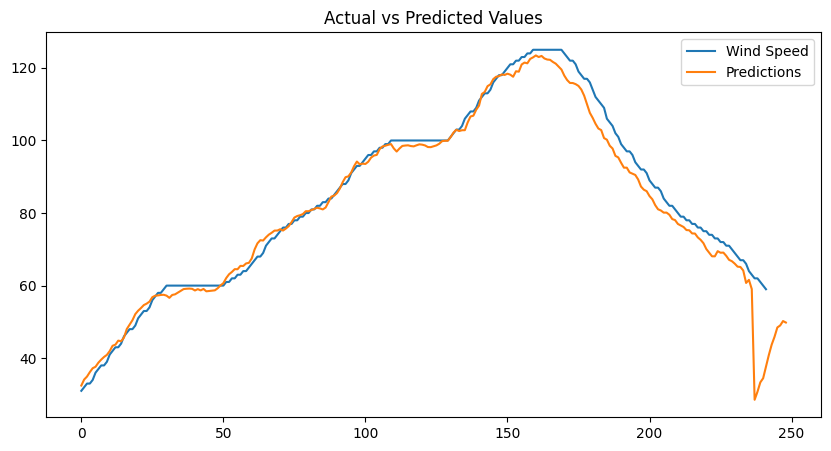

This model performed very well in the fitting of earlier data, but obvious anomalies were found later, and when the final prediction was made, the result was gradually far away from our true value, so it is considered that the fitting result is not good.

## ConvLSTM: Non Time-Series Approach

We decided to try using a similar ConvLSTM model but not window the images and features. This way we can randomly shuffle and the model can potentially learn better off of characteristics of images.

### Data Loader

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam

from ipywidgets import widgets, HBox
from torchvision.transforms import functional as TF
from torchvision import transforms
from PIL import Image

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from prediction import HurricaneDataset, Seq2Seq
from torchvision.models import resnet18

In [ ]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms


import json

class HurricaneDataset(Dataset):
    def __init__(self, image_folder, transform=None, image_size=(64, 64), channels=1):
        """
        Initialize the dataset.
        Args:
            image_folder (string): Path to folder containing images and label files.
            transform (callable, optional): Transform to be applied on an image.
            image_size (tuple): Target size for the images.
            channels (int): Number of channels in the images (1 for grayscale, 3 for RGB).
        """
        self.image_folder = image_folder
        self.channels = channels
        self.transform = transform if transform else self.default_transform(image_size)
        self.samples = self._load_samples()

    def _load_samples(self):
        """
        Load all image file paths from the folder.
        """
        return [os.path.join(self.image_folder, file) for file in sorted(os.listdir(self.image_folder)) if file.endswith('.jpg')]

    def default_transform(self, image_size):
        """
        Define default transformation: Resize, Convert to RGB or Grayscale, and Convert to Tensor.
        """
        transform_list = [transforms.Resize(image_size)]
        if self.channels == 1:
            transform_list.append(transforms.Grayscale(num_output_channels=1))
        elif self.channels == 3:
            transform_list.append(transforms.Lambda(lambda img: img.convert('RGB')))
        transform_list.append(transforms.ToTensor())
        return transforms.Compose(transform_list)

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Fetch an item (image and label) from the dataset.
        """
        image_path = self.samples[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        base_filename = os.path.splitext(os.path.basename(image_path))[0]
        label_filename = f"{base_filename}_label.json"
        label_path = os.path.join(self.image_folder, label_filename)

        with open(label_path, 'r') as label_file:
            label_data = json.load(label_file)
            wind_speed = label_data['wind_speed']

        return image, wind_speed


Our other approach was to use a non pretrained CNN as the basis for the ConvLSTM. This due to the fact that training our own model from scratch that had less parameters is more efficient than using a pretrained model when It comes to training.

Therefore we decided for the architecture seen on the left. Let’s dive into it.

Key Components:

* ConvLSTMCell:
    * The core of the model is the ConvLSTMCell, a modified LSTM cell that incorporates convolutional operations.
    * It is designed to process spatial data within the LSTM's temporal framework, to capture both the spatial and temporal features.
    * The cell uses convolutional layers to handle the input-to-state and state-to-state transitions within the LSTM mechanism.

* ConvLSTM Layer:
    * The model uses layers of ConvLSTMCell to process the input data.
    * Each ConvLSTM layer handles the input image (or the output from the previous layer) and maintains its own hidden state and cell state.

* Sequential Architecture:
    * The model is composed of multiple ConvLSTM layers, stacked sequentially.
    * Batch normalization (BatchNorm2d) is applied after each ConvLSTM layer to stabilise and speed up training.

* Fully Connected Layers:
    * After the sequential ConvLSTM layers, the output is flattened and passed through fully connected layers.
    * The final output layer (fc_out) produces a single value representing the predicted wind speed.

* We also made one very important change from the previous model in terms of input.
    * Initially, a windowing approach was considered to treat the data as a time series, expecting to leverage the temporal sequence of images. However, this method did not yield the expected results.
    * It was observed that treating each image individually and teaching the model to label images based on single instances led to better performance. This could be due to the model more effectively focusing on spatial features. 
    * Through our testing we found it performed significantly better when randomly shuffling them 

In [ ]:
import torch
import torch.nn as nn


# Original ConvLSTM cell as proposed by Shi et al.
class ConvLSTMCell(nn.Module):

    def __init__(self, in_channels, out_channels,
                 kernel_size, padding, activation, frame_size):

        super(ConvLSTMCell, self).__init__()

        if activation == "tanh":
            self.activation = torch.tanh
        elif activation == "relu":
            self.activation = torch.relu

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels,
            out_channels=4 * out_channels,
            kernel_size=kernel_size,
            padding=padding)

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1) # noqa

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev)
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev)

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C)

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C


In [ ]:
import torch.nn as nn
import torch

class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels,
                 kernel_size, padding, activation, frame_size):

        super(ConvLSTM, self).__init__()

        self.frame_size = frame_size

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels,
                                         kernel_size, padding, activation,
                                         frame_size)

    def forward(self, X):
        # X is a single image (batch_size, num_channels, height, width)

        # Initialize Hidden State and Cell State
        H = torch.zeros(X.size(0), self.out_channels, *self.frame_size, device=X.device)
        C = torch.zeros(X.size(0), self.out_channels, *self.frame_size, device=X.device)

        # Forward pass through the ConvLSTMCell
        H, C = self.convLSTMcell(X, H, C)

        return H


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, num_channels, num_kernels, kernel_size, padding, activation, frame_size, num_layers, fc_size):
        super(Seq2Seq, self).__init__()

        self.sequential = nn.Sequential()

        # Add the first ConvLSTM layer
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding,
                activation=activation, frame_size=frame_size)
        )

        # Use BatchNorm2d instead of BatchNorm3d
        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm2d(num_features=num_kernels)
        )

        # Add the rest of the ConvLSTM layers
        for layer_num in range(2, num_layers + 1):
            self.sequential.add_module(
                f"convlstm{layer_num}", ConvLSTM(
                    in_channels=num_kernels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding,
                    activation=activation, frame_size=frame_size)
            )

            # Again, use BatchNorm2d
            self.sequential.add_module(
                f"batchnorm{layer_num}", nn.BatchNorm2d(num_features=num_kernels)
            )

        # The output of the last ConvLSTM layer will be flattened and passed to the following layers
        self.fc = nn.Linear(num_kernels * frame_size[0] * frame_size[1], fc_size)
        self.fc_out = nn.Linear(fc_size, 1)  # Output one value for wind speed

    def forward(self, X):
        # Forward propagation through all ConvLSTM layers
        output = self.sequential(X)

        # Flatten the output for the fully connected layer
        output = output.flatten(start_dim=1)

        # Forward through fully connected layers
        output = F.relu(self.fc(output))
        output = self.fc_out(output)

        return output.squeeze()


Below you can see a diagram depicting how my model processes the input.

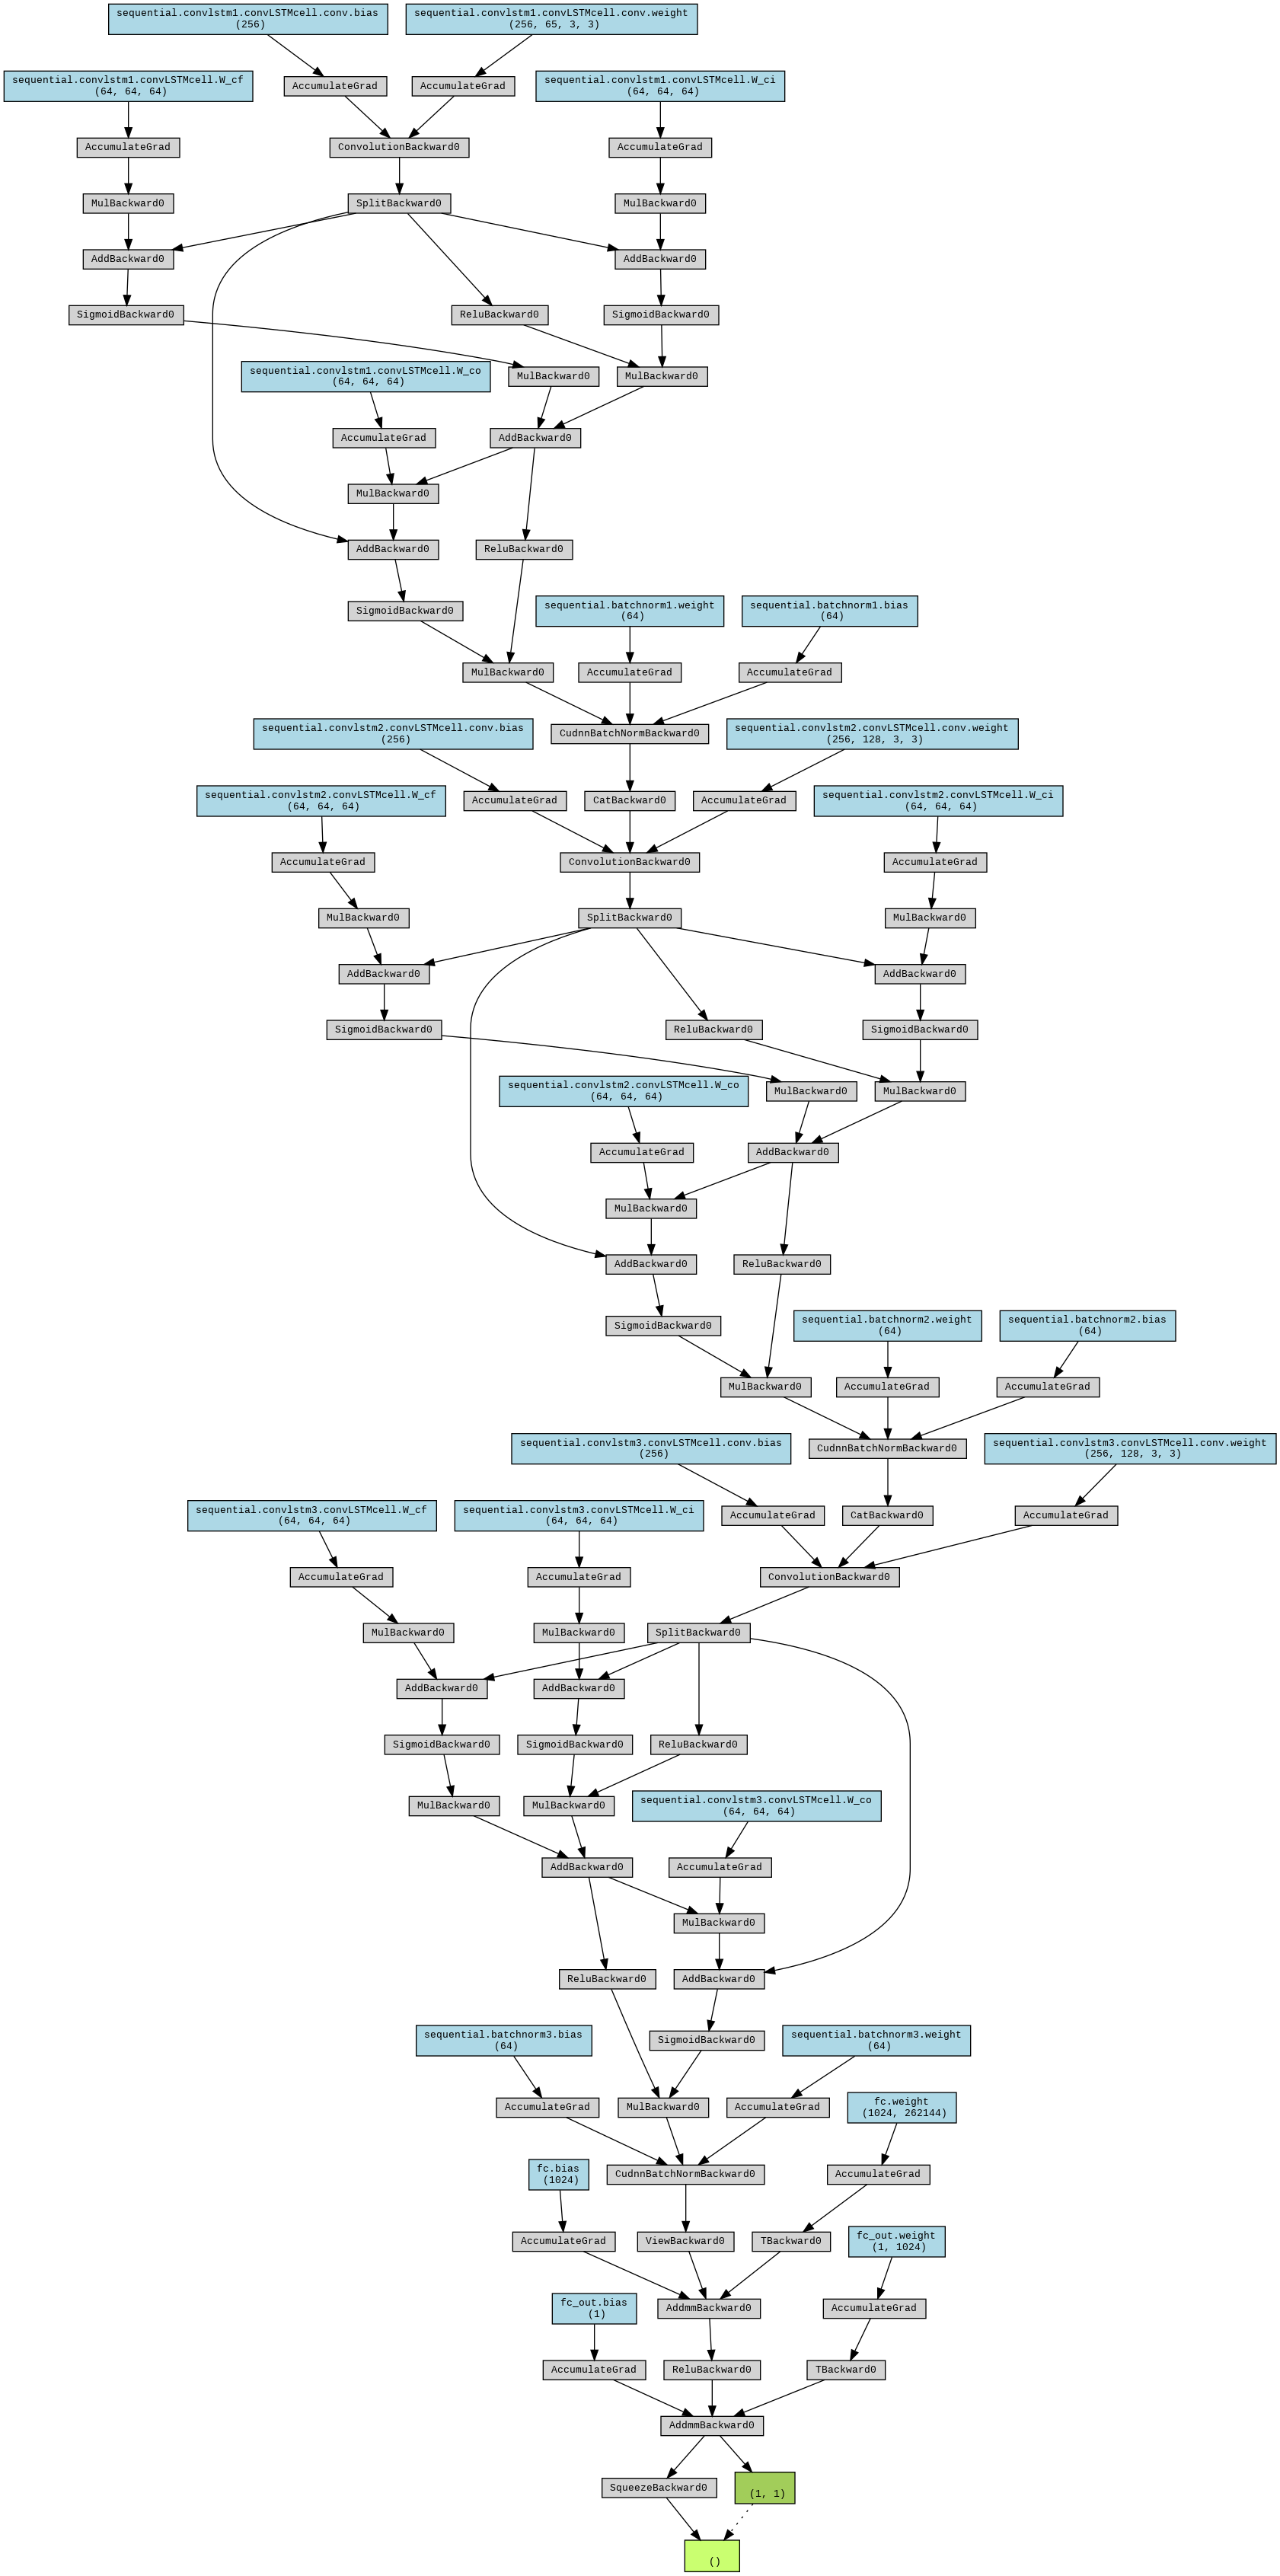

Besides the model implementation, the dataloader is almost identical to earlier in the notebook.

In [ ]:
!unzip /content/bkh.zip -d /content/data/

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

* Flexibility: The workflow is designed to be adaptable. For instance, the HurricaneDataset can switch between training and inference modes. This flexibility is crucial for developing models that can be easily adjusted and tested under different conditions.
* Efficiency: By dividing the dataset and using data loaders, the workflow is optimized for computational efficiency, making it suitable for processing large datasets typically involved in image-based tasks.
* Proper Evaluation: Separating the dataset into training and validation sets and then evaluating the model on the validation set provides a clear understanding of the model's performance and generalisation capabilities.

Below we are shuffling and randomly splitting the entire dataset. We can do this (even though it is a time series) because we don't treat it as a time series and look at each image completely separately and not in sequence to the other images.

In [ ]:
from sklearn.model_selection import train_test_split

def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {'train': Subset(dataset, train_idx), 'val': Subset(dataset, val_idx)}
    return datasets

dataset = HurricaneDataset(image_folder='/content/data/bkh', image_size=(64, 64), channels=1)
datasets = train_val_dataset(dataset)

def collate(batch):
    images = torch.stack([item[0] for item in batch], dim=0)
    labels = torch.tensor([float(item[1]) for item in batch], dtype=torch.float32)
    return images, labels


train_loader = DataLoader(datasets['train'], batch_size=4, shuffle=True, collate_fn=collate)
val_loader = DataLoader(datasets['val'], batch_size=4, shuffle=False, collate_fn=collate)

train, _ = next(iter(train_loader))
print(train.shape)
print(_.shape)

The parameters below were selected using manula case by case basis. Not all options were tried as for example increasing the fc_size made the model perform worse due to forcing the model to find more complex patterns. This resulted in worse results so we did not increase this parameter any further. The same logic was used for other parameters,

In [ ]:
model = Seq2Seq(num_channels=1, num_kernels=64,
                kernel_size=(3, 3), padding=(1, 1), activation="relu",
                frame_size=(64, 64), num_layers=6, fc_size=128).to(device)


optimizer = Adam(model.parameters(), lr=1e-3)

criterion = nn.L1Loss(reduction='mean')

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch

def train_model_with_plot(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device=device):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1)

            optimizer.zero_grad()
            outputs = model(inputs).view(-1)

            loss = criterion(outputs, targets)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                
                val_loss += criterion(outputs, targets).item()

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}")


train_model_with_plot(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)


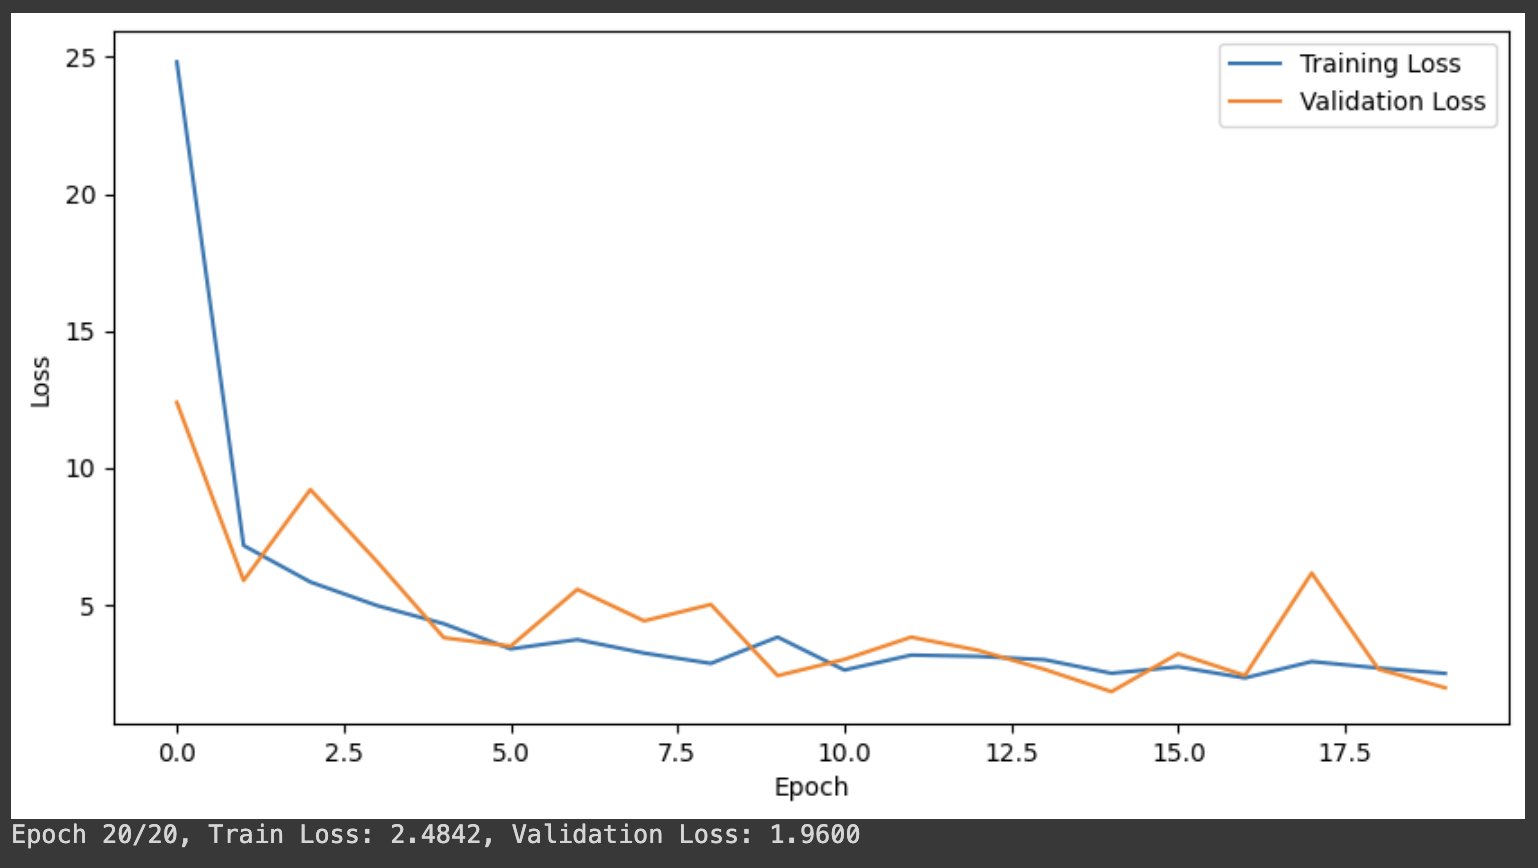

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_predicted_vs_actual(model, data_loader, num_samples=5, device='cuda'):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if i >= num_samples:
                break

            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)

            predictions.extend(outputs.view(-1).cpu().numpy())
            actuals.extend(targets.view(-1).cpu().numpy())

    samples = np.arange(len(predictions))

    plt.figure(figsize=(10, 6))
    plt.scatter(samples, predictions, label='Predicted', color='blue')
    plt.plot(samples, predictions, color='blue')
    plt.scatter(samples, actuals, label='Actual', color='orange', alpha=0.7)
    plt.plot(samples, actuals, color='orange')
    plt.title('Comparison of Predicted and Actual Wind Speeds')
    plt.xlabel('Sample')
    plt.ylabel('Wind Speed')
    plt.legend()
    plt.show()

plot_predicted_vs_actual(model, val_loader, num_samples=20)


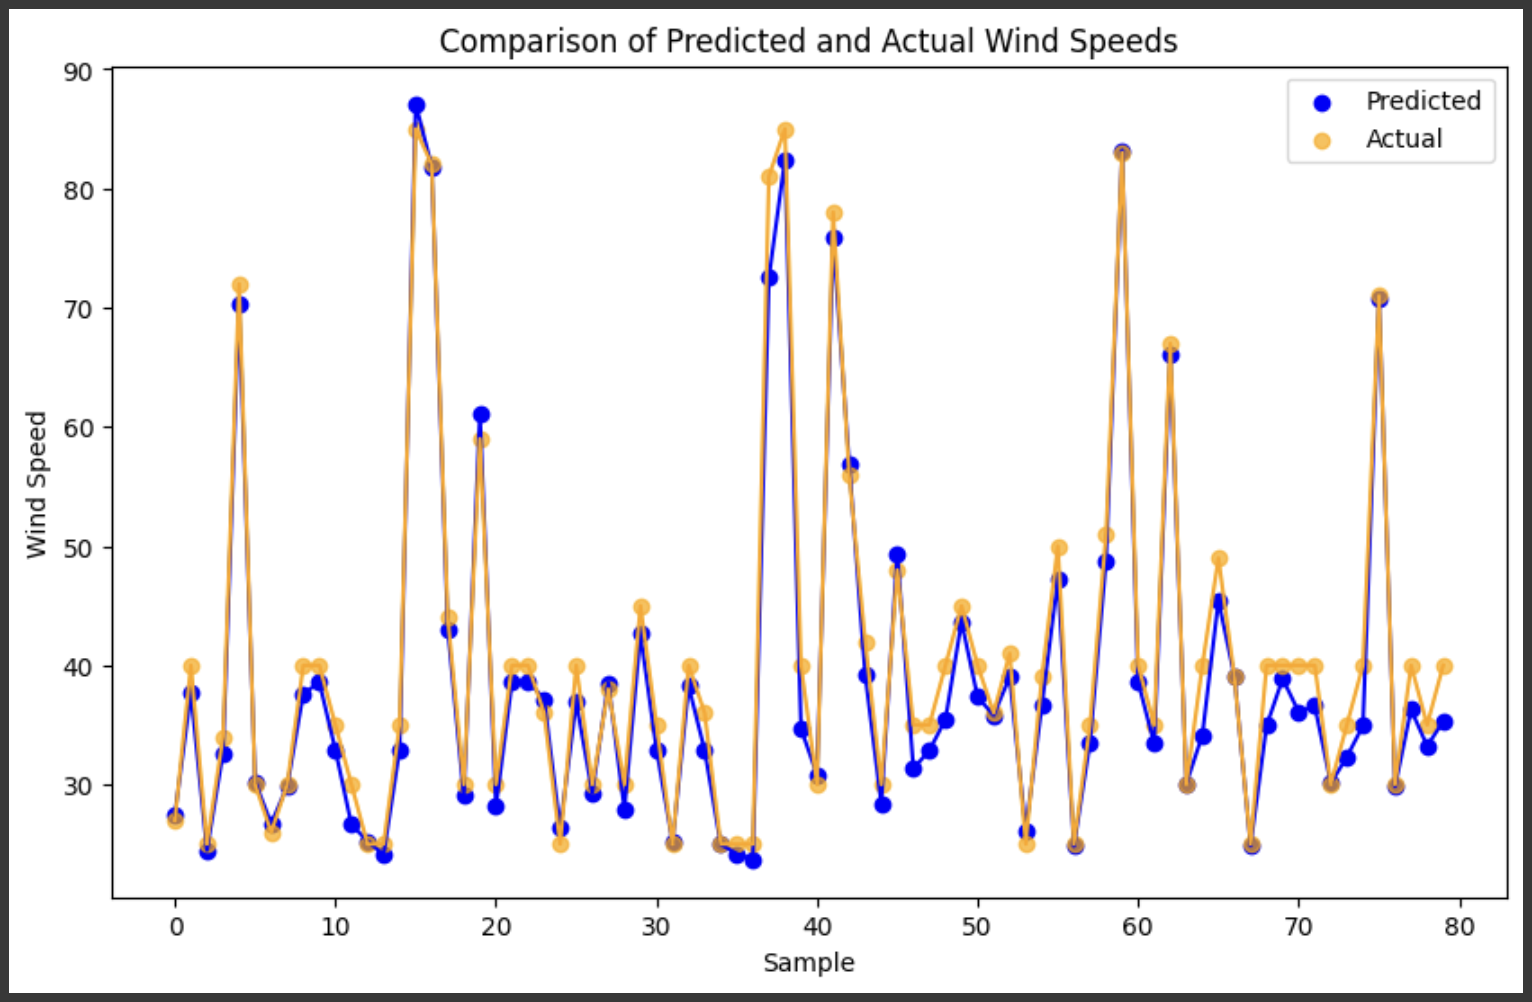

As you can tell from the above plot and the validation loss, the model performed incredibly well on predicting one storm. The entire storm was randomly split and shuffled so the model saw images throughout the entire storm and therefore, was able to generalise to the all the images.

We decided for the surprise storm to not window the sequence and to treat the images as not part of a time series.